## Proyecto final - Predicción de Obesidad a partir de hábitos de vida

### Resúmen ejecutivo

-- 

Los hallazgos más relevantes son:

--

**Introducción**

El presente proyecto usa los datos del dataset `ObesityDataset_raw_and_data_sinthetic.csv` para entender las variables, realizar las limpiezas y transformaciones necesarias para lograr un modelo supervisado y no supervisado que permita agrupar o predecir el tipo de obsesidad de una persona de acuerdo con sus hábitos de vida.

**Metodoligía**

--

**Resultados**

--

**Conclusiones y recomendaciones**

--

**Referencias**

--



In [1]:
# importar las librerías

import pandas as pd
import numpy as np

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para preprocesamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Librerías para modelos supervisados
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

# Librerías para modelos no supervisados
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

# Librerías para evaluación de modelos
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Configuración de visualización
sns.set_style("darkgrid")
sns.set_palette("pastel")


In [2]:
# cargar los datos

df = pd.read_csv('./data_raw/obesity_habits.csv')

df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
# información del dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [4]:
# información del dataset

cat_var = df.select_dtypes(include='object').columns
num_var = df.select_dtypes(include='number').columns

print(f'Variables categóricas: {len(cat_var)}')
print(f'Variables numéricas: {len(num_var)}')
print(f'Número de registros: {df.shape[0]}')
print(f'Número de columnas: {df.shape[1]}')

Variables categóricas: 9
Variables numéricas: 8
Número de registros: 2111
Número de columnas: 17


**Análisis de las variables**

En el dataset se observan 9 variables categóricas y 8 variables numéricas. En estas variables encontramos información sobre los hábitos alimenticios de las personas y algunos datos sobre su descripción física. Las variables `Gender`, `Age`, `Height`, `Weight` y `family_history_with_overweight`, son descriptivas del físico de las personas y su historial de sobrepeso familiar. A continuación graficamos estas variables.

In [5]:
cat_var

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

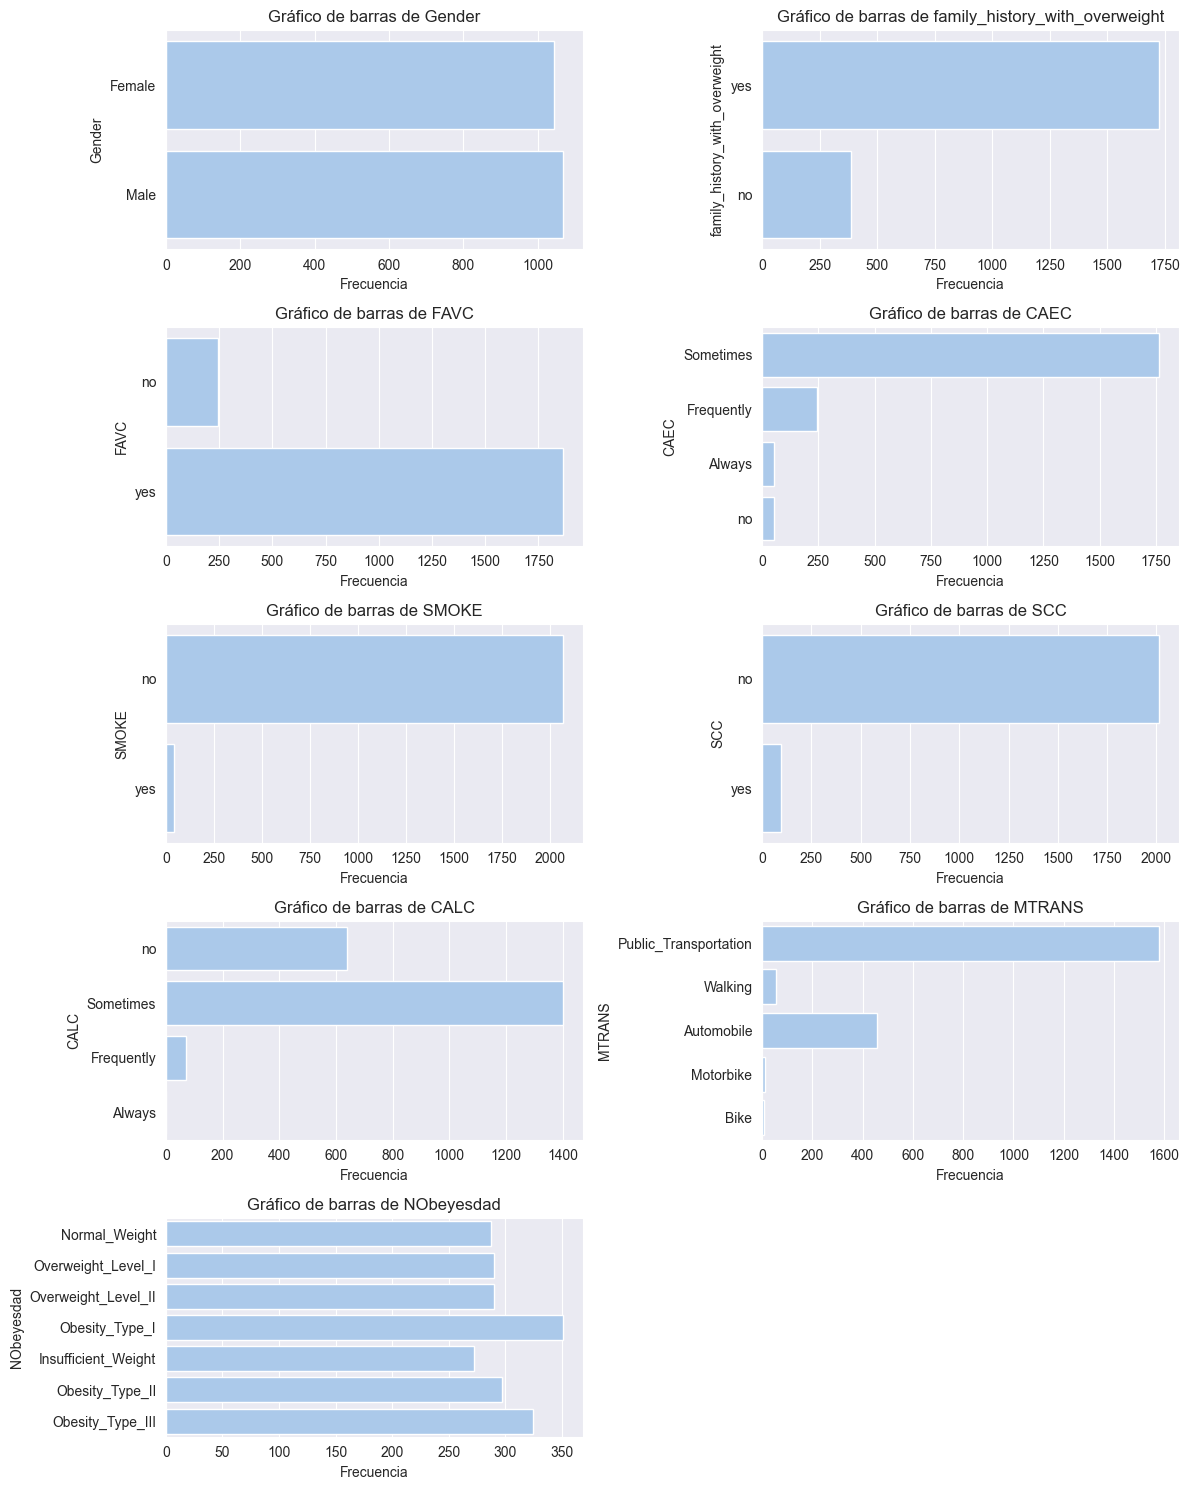

In [6]:
# graficar las variables categóricas

plt.figure(figsize=(12, 15))
for i, var in enumerate(cat_var, 1):
    plt.subplot(5, 2, i)
    sns.countplot(y=var, data=df)
    plt.title(f'Gráfico de barras de {var}')
    plt.xlabel('Frecuencia')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

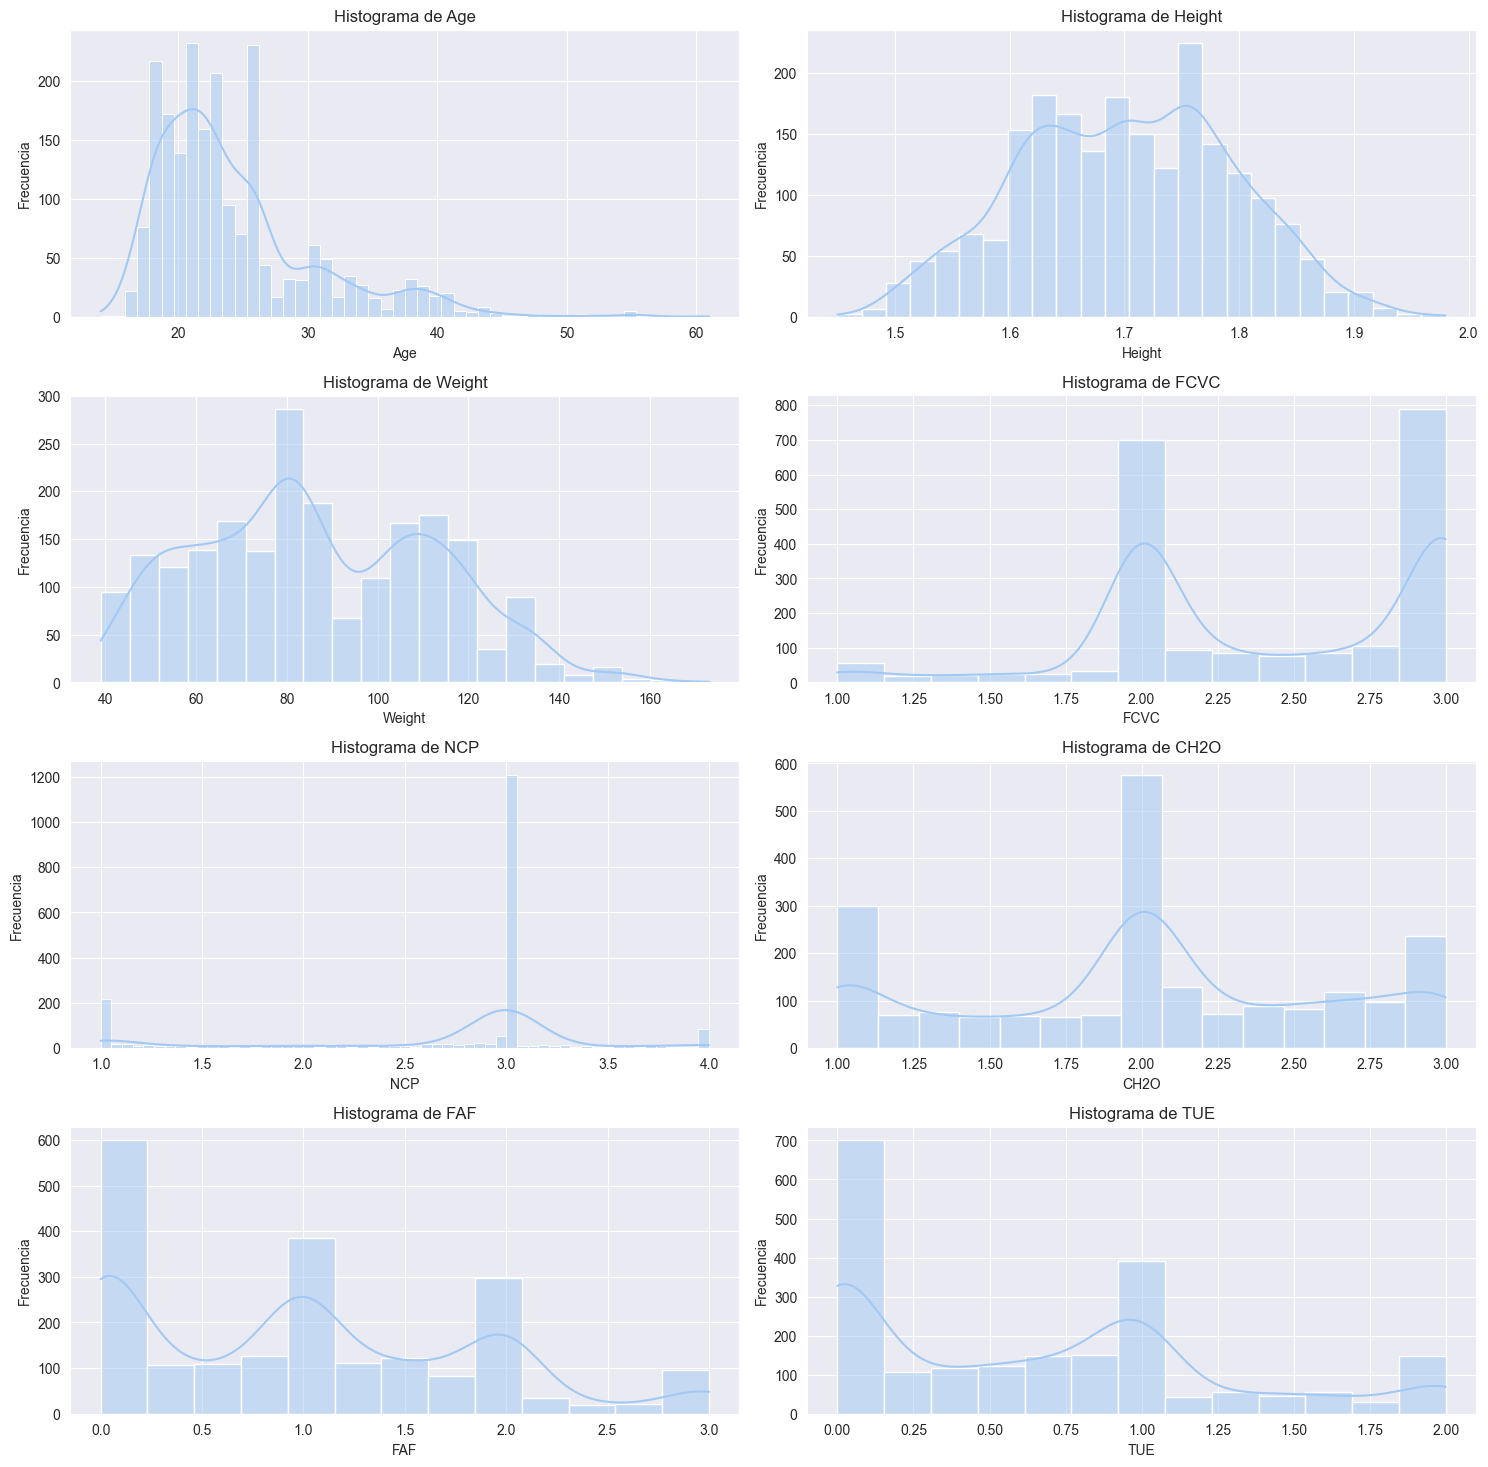

In [7]:
# graficar las variables numéricas

plt.figure(figsize=(15, 18))

for i, var in enumerate(num_var, 1):
    plt.subplot(5, 2, i)
    sns.histplot(df[var], kde=True)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [8]:
# valores unicos en las variables numéricas

for var in num_var:
    print(f'Valores únicos en {var}: {df[var].nunique()}')


Valores únicos en Age: 1402
Valores únicos en Height: 1574
Valores únicos en Weight: 1525
Valores únicos en FCVC: 810
Valores únicos en NCP: 635
Valores únicos en CH2O: 1268
Valores únicos en FAF: 1190
Valores únicos en TUE: 1129


Se observa que las variables categóricas tienen una distribución de frecuencia que parece indicar que los individuos de la muestra tienen, en mayor proporción, hábitos saludables, de no ser fumadores, beber licor en algunas ocaciones, algunas veces comen entre comidas, sin embargo, no monitorean la cantidad de calorías que comen, comen comida con altas calorías y muy pocos caminan o usan bicicleta como medio de transporte.

En la variables numéricas se pierde un poco la lectura, ya que encontramos tres y cuatro valores numéricos flotantes,  que pueden convertirse a enteros con redondeo simple y luego en categóricos ordinales para conservar la misma estructura vista en las variables categóricas. Esto puede ayudar al modelo de agrupación o de predicción, así que se realizará esta transformación como primer paso para los siguientes análisis exploratorios.

In [9]:
# redondear las variables numéricas `Age`, `FCVC`, `CH2O`, `NCP`,`FAF` y `TUE` con cero decimales

df['Age'] = df['Age'].round(0)
df['FCVC'] = df['FCVC'].round(0)
df['CH2O'] = df['CH2O'].round(0)
df['FAF'] = df['FAF'].round(0)
df['TUE'] = df['TUE'].round(0)
df['NCP'] = df['NCP'].round(0)


# cambiar el tipo de dato a categorico

df['FCVC'] = df['FCVC'].astype('object')
df['CH2O'] = df['CH2O'].astype('object')
df['FAF'] = df['FAF'].astype('object')
df['TUE'] = df['TUE'].astype('object')
df['NCP'] = df['NCP'].astype('object')

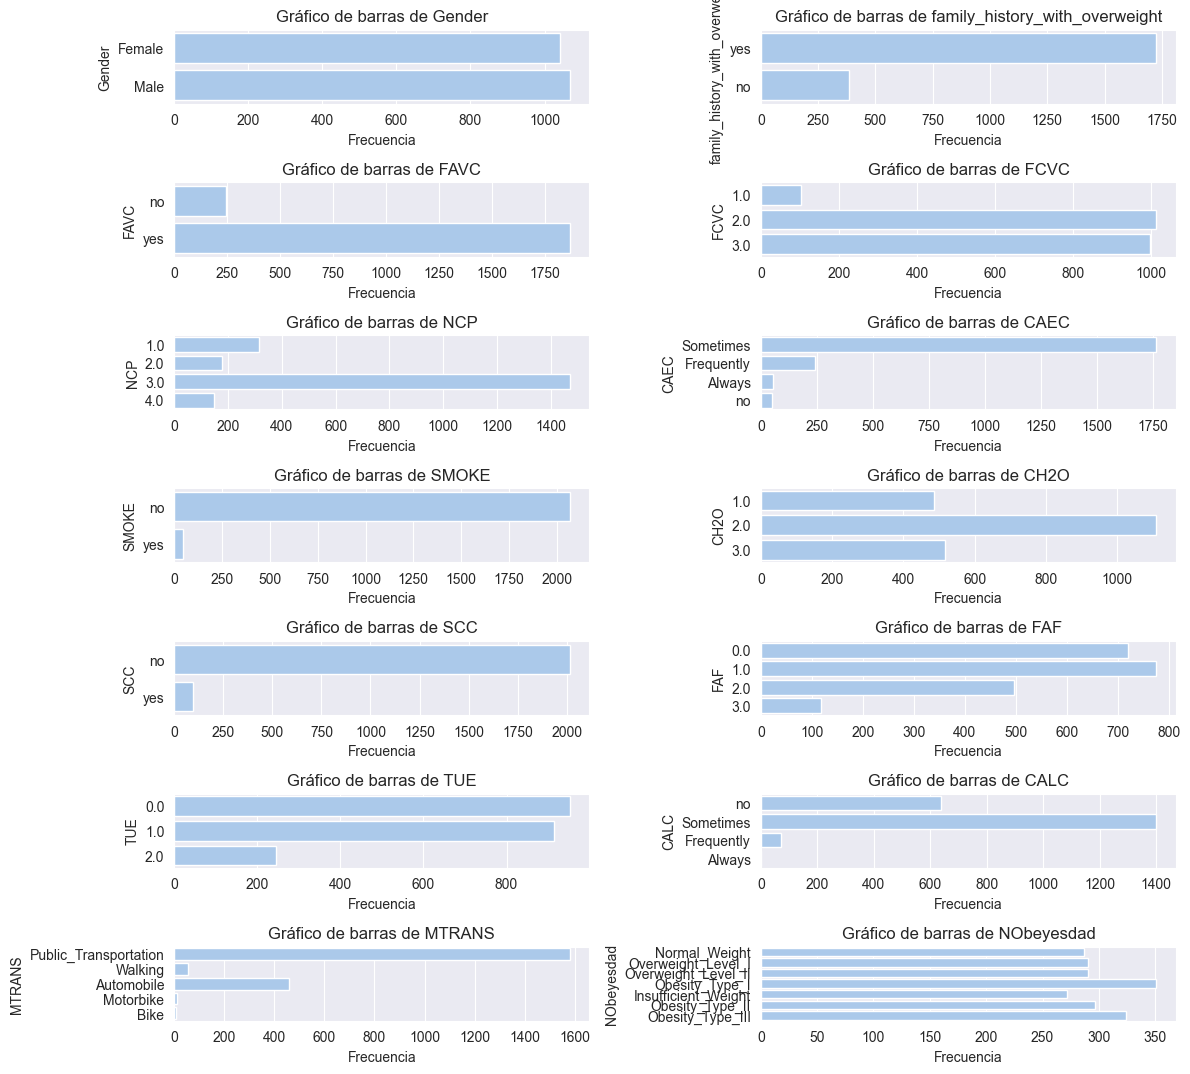

In [10]:
# graficar las variables categóricas

cat_var = df.select_dtypes(include='object').columns

plt.figure(figsize=(12, 15))
for i, var in enumerate(cat_var, 1):
    plt.subplot(10, 2, i)
    sns.countplot(y=var, data=df)
    plt.title(f'Gráfico de barras de {var}')
    plt.xlabel('Frecuencia')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

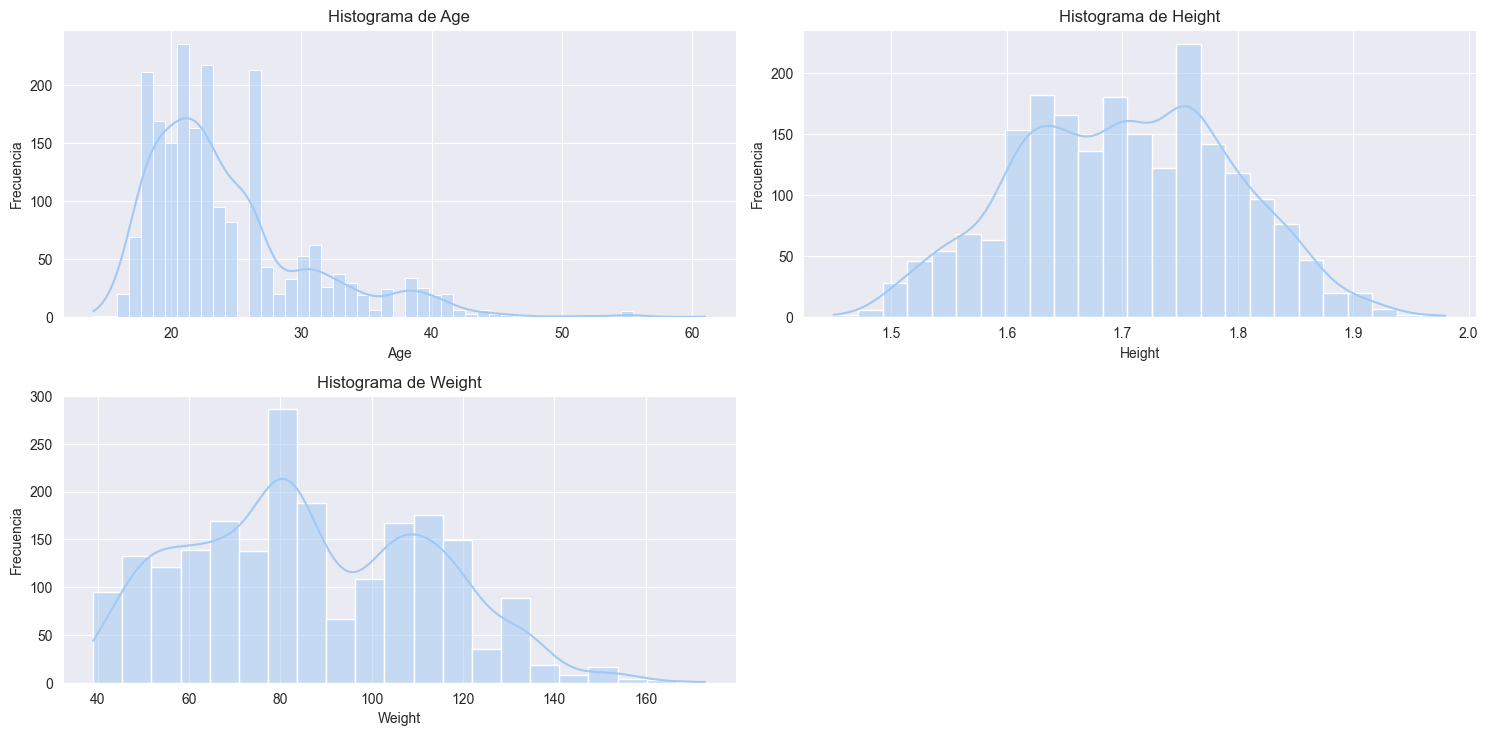

In [11]:
# graficar las variables numéricas

num_var = df.select_dtypes(include='number').columns

plt.figure(figsize=(15, 18))

for i, var in enumerate(num_var, 1):
    plt.subplot(5, 2, i)
    sns.histplot(df[var], kde=True)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

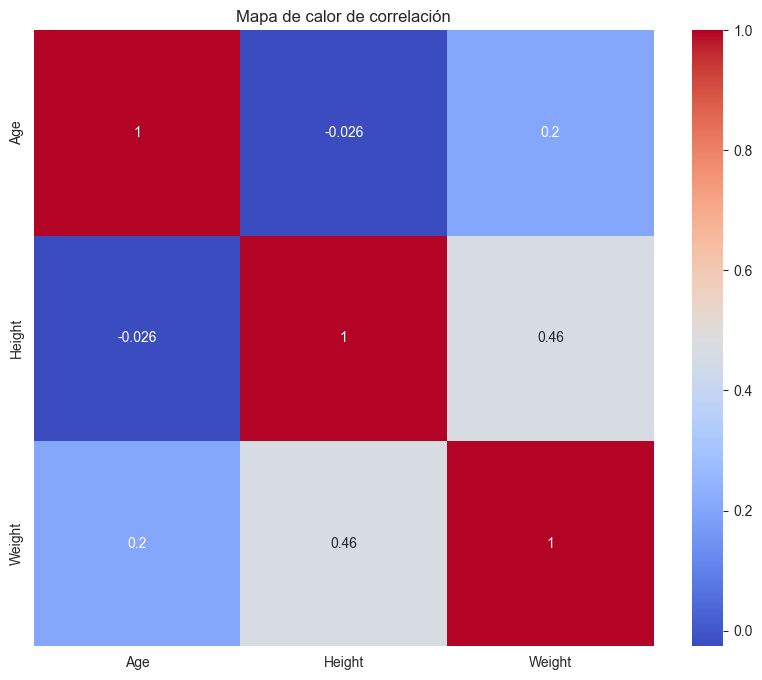

In [12]:
# graficar la correlación entre las variables numéricas

plt.figure(figsize=(10, 8))
sns.heatmap(df[num_var].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlación')
plt.show()

En el análisis de correlación, se observa una correlación alta entre la altura y el peso. Podemos seleccionar una de las variables para evitar la multicolinealidad. En los siguientes pasos se prepararán los datos para hacer el ajuste de modelo supervisado y no supervisado.

In [13]:
# selección de variables

X = df.drop(columns=['NObeyesdad', 'Height', 'Weight'])
y = df['NObeyesdad']

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   family_history_with_overweight  2111 non-null   object 
 3   FAVC                            2111 non-null   object 
 4   FCVC                            2111 non-null   object 
 5   NCP                             2111 non-null   object 
 6   CAEC                            2111 non-null   object 
 7   SMOKE                           2111 non-null   object 
 8   CH2O                            2111 non-null   object 
 9   SCC                             2111 non-null   object 
 10  FAF                             2111 non-null   object 
 11  TUE                             2111 non-null   object 
 12  CALC                            21

In [15]:
# aplicar label encoder a ls variables categóricas

le = LabelEncoder()

for var in X.select_dtypes(include='object').columns:
    X[var] = le.fit_transform(X[var])

y = le.fit_transform(y)

In [16]:
# escalado de las variables

scaler = StandardScaler()

X['Age'] = scaler.fit_transform(X['Age'].values.reshape(-1, 1))

In [17]:
X

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0,-0.521741,1,0,1,2,2,0,1,0,0,1,3,3
1,0,-0.521741,1,0,2,2,2,1,2,1,3,0,2,3
2,1,-0.207057,1,0,1,2,2,0,1,0,2,1,1,3
3,1,0.422312,0,0,2,2,2,0,1,0,2,0,1,4
4,1,-0.364399,0,0,1,0,2,0,1,0,0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,-0.521741,1,1,2,2,2,0,1,0,2,1,2,3
2107,0,-0.364399,1,1,2,2,2,0,1,0,1,1,2,3
2108,0,-0.207057,1,1,2,2,2,0,1,0,1,1,2,3
2109,0,-0.049714,1,1,2,2,2,0,2,0,1,1,2,3


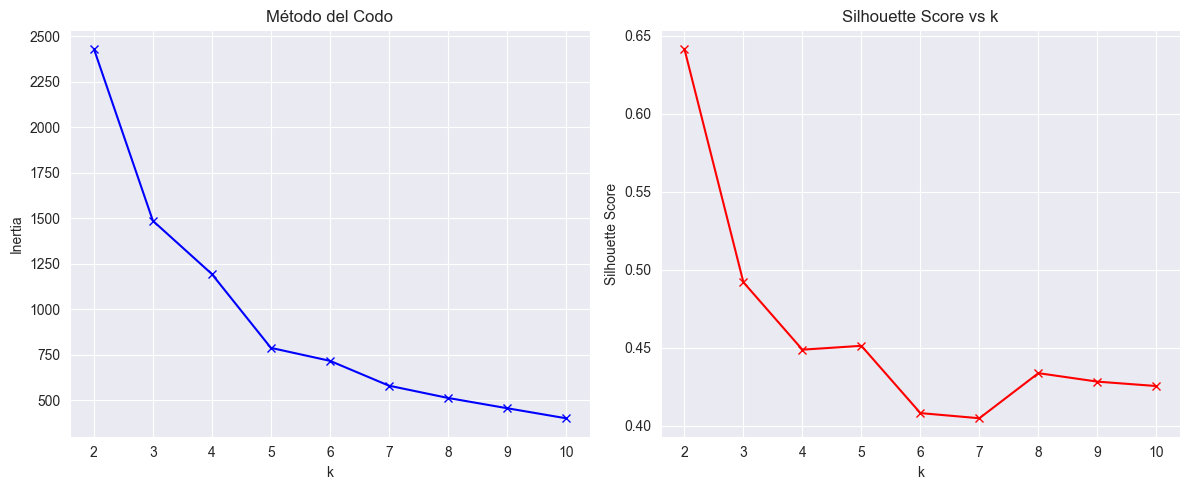

In [18]:
# reducir la dimensionalidad

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

# encontrar el número de clusters

inertia = []
silhouette_scores = []

K = range(2,11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# visualización del método del codo

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Método del Codo')

plt.subplot(1, 2, 2)

plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.tight_layout()
plt.show()


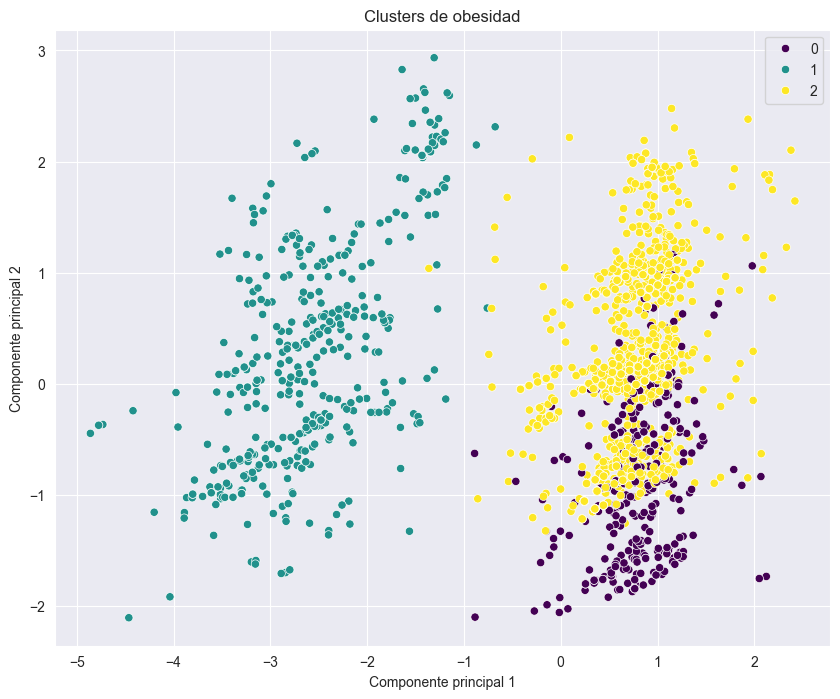

In [25]:
# entrenar el modelo

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# predecir los clusters

clusters = kmeans.predict(X)

# visualizar los clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title('Clusters de obesidad')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

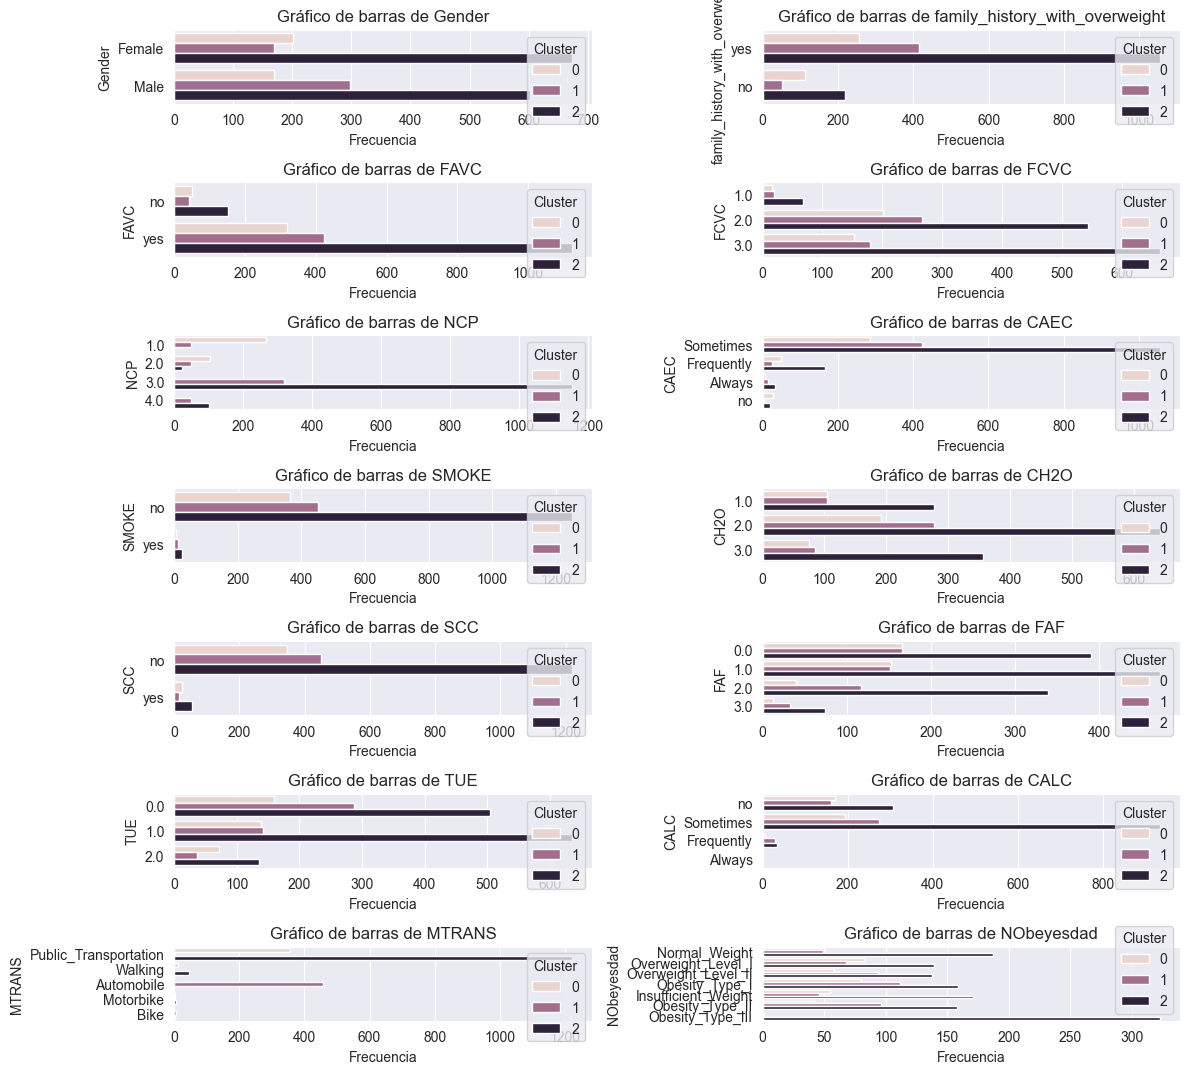

In [27]:
# agregar los clusters al dataset

df['Cluster'] = clusters

# graficar las variables categóricas

cat_var = df.select_dtypes(include='object').columns

plt.figure(figsize=(12, 15))
for i, var in enumerate(cat_var, 1):
    plt.subplot(10, 2, i)
    sns.countplot(y=var, data=df, hue='Cluster')
    plt.title(f'Gráfico de barras de {var}')
    plt.xlabel('Frecuencia')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

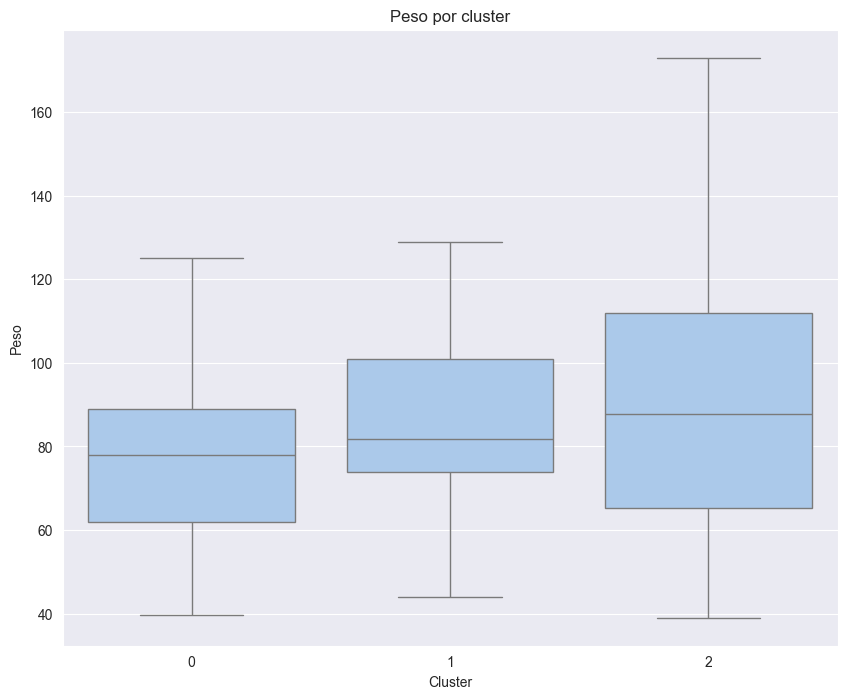

In [28]:
# graficar el peso por cluster

plt.figure(figsize=(10, 8))
sns.boxplot(x='Cluster', y='Weight', data=df)
plt.title('Peso por cluster')
plt.xlabel('Cluster')
plt.ylabel('Peso')
plt.show()

In [29]:
# mediana del peso por cluster

df.groupby('Cluster')['Weight'].median()

Cluster
0    78.000000
1    81.873048
2    87.656029
Name: Weight, dtype: float64

Se observa que para el modelo no supervisado se agrupan 3 clusters donde el cluster 0 están las personas con peso medio de 56, para el cluster 2 un peso edio de 102 y para el cluster 3 un peso medio de 83. Esta agrupación parece no estar correspondiendo a la variable objetivo, pues se observa que hay concentración de todos los cluster en todos los niveles de obesidad.

Ahora ajustaremos el modelo supervisado y obtener las conclusiones en conjunto.

In [ ]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

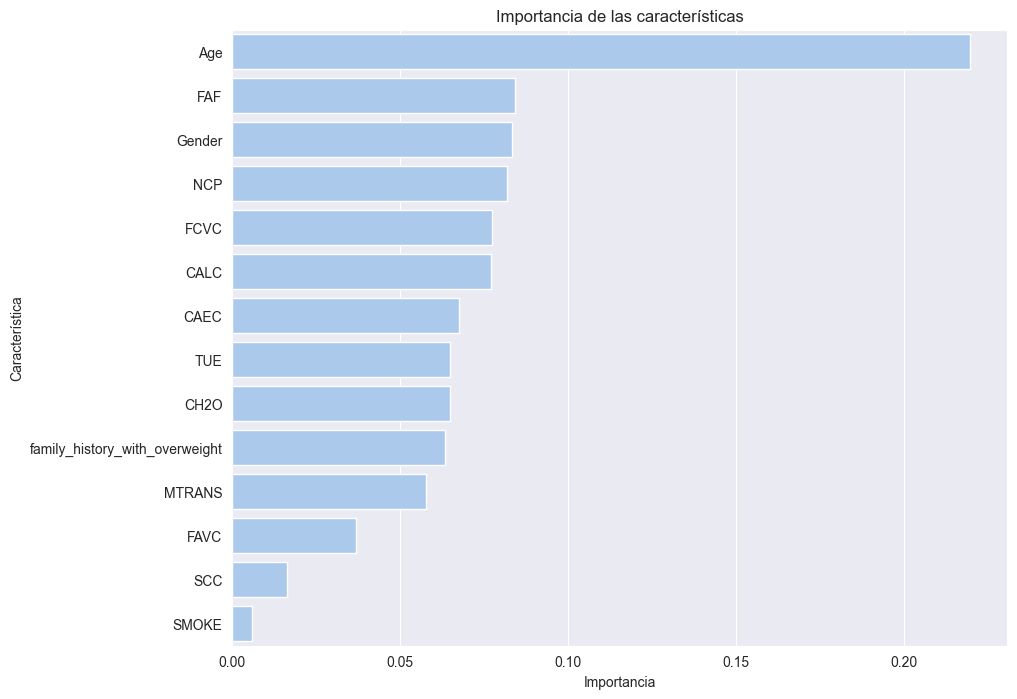

In [31]:
# selección de caracteristicas usando Random Forest

rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X,y)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_selector.feature_importances_
})

plt.figure(figsize=(10, 8))

sns.barplot(x='Importance', y='Feature', data=feature_importances.sort_values(by='Importance', ascending=False))
plt.title('Importancia de las características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()


In [ ]:
# seleccionar las características más importantes

selector = SelectFromModel(rf_selector, prefit=True, max_features=14)
X_selected = selector.transform(X_scaled)
selected_features = X_scaled.columns[selector.get_support()].tolist()

c:\Users\ingen\Documents\estudio\especializacion_ml\esp_ml_env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
# preparar los datos para el modelo

# X_selected = X[selected_features]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_selected)

In [33]:
# dividir los datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# comparación de modelos

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

In [35]:
# evaluación de los modelos

results = {}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[model_name] = {
        'CV mean': cv_scores.mean(),
        'CV std': cv_scores.std()
    }

results_df = pd.DataFrame(results).T
print("\nResultados de la validación cruzada\n")
print(results_df)
    


Resultados de la validación cruzada

                    CV mean    CV std
Random Forest      0.789688  0.018569
Gradient Boosting  0.767173  0.025747
XGBoost            0.790280  0.020339
SVM                0.689572  0.030535


In [36]:
# optimizar el mejor modelo (XGBoost)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1]
}

xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor score: {grid_search.best_score_}")


Mejores parámetros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5}
Mejor score: 0.7867311642933646


In [37]:
# entrenar el modelo optimizado

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [38]:
# evaluar el modelo

y_pred = best_model.predict(X_test)

print("\nReporte de clasificación\n")
print(classification_report(y_test, y_pred))


Reporte de clasificación

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        56
           1       0.70      0.61      0.66        62
           2       0.83      0.81      0.82        78
           3       0.80      0.95      0.87        58
           4       0.95      1.00      0.98        63
           5       0.79      0.75      0.77        56
           6       0.72      0.62      0.67        50

    accuracy                           0.81       423
   macro avg       0.80      0.80      0.80       423
weighted avg       0.80      0.81      0.80       423



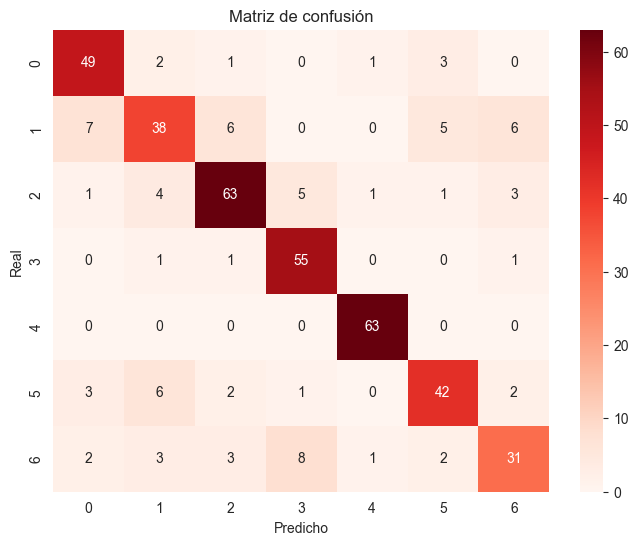

In [39]:
# matriz de confusión

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Matriz de confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [40]:
# analisis de errores

errors = pd.DataFrame({
    'Real': le.inverse_transform(y_test),
    'Predicho': le.inverse_transform(y_pred),
    'Correcto': y_test == y_pred
})

print("\nErrores de clasificación\n")
print(errors.groupby('Real')['Correcto'].mean())


Errores de clasificación

Real
Insufficient_Weight    0.875000
Normal_Weight          0.612903
Obesity_Type_I         0.807692
Obesity_Type_II        0.948276
Obesity_Type_III       1.000000
Overweight_Level_I     0.750000
Overweight_Level_II    0.620000
Name: Correcto, dtype: float64


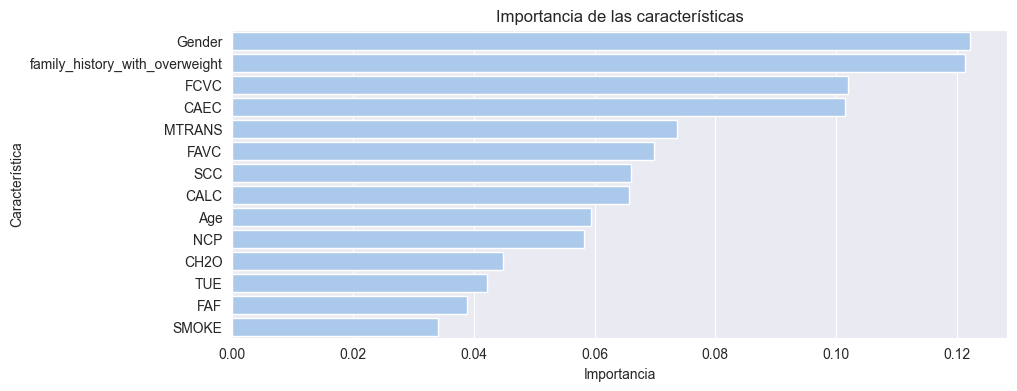

In [41]:
# importancia de características en el modelo optimizado

feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb)
plt.title('Importancia de las características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

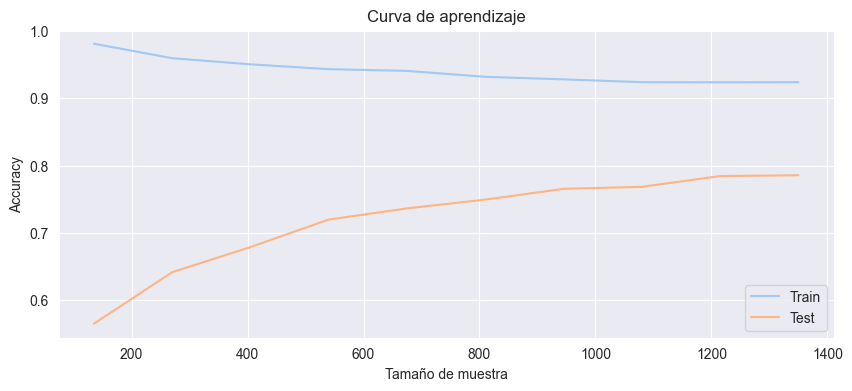

In [42]:
# curva de aprendizaje

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model, 
                                                        X_train, 
                                                        y_train, cv=5,
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')

plt.figure(figsize=(10, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.title('Curva de aprendizaje')
plt.xlabel('Tamaño de muestra')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

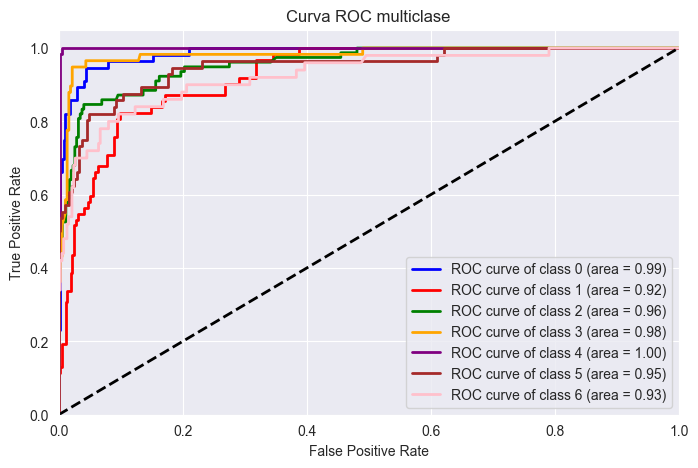

In [43]:
# curva ROC multiclase

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_bin.shape[1]

y_score = best_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 5))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC multiclase')
plt.legend(loc="lower right")
plt.show()

c:\Users\ingen\Documents\estudio\especializacion_ml\esp_ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


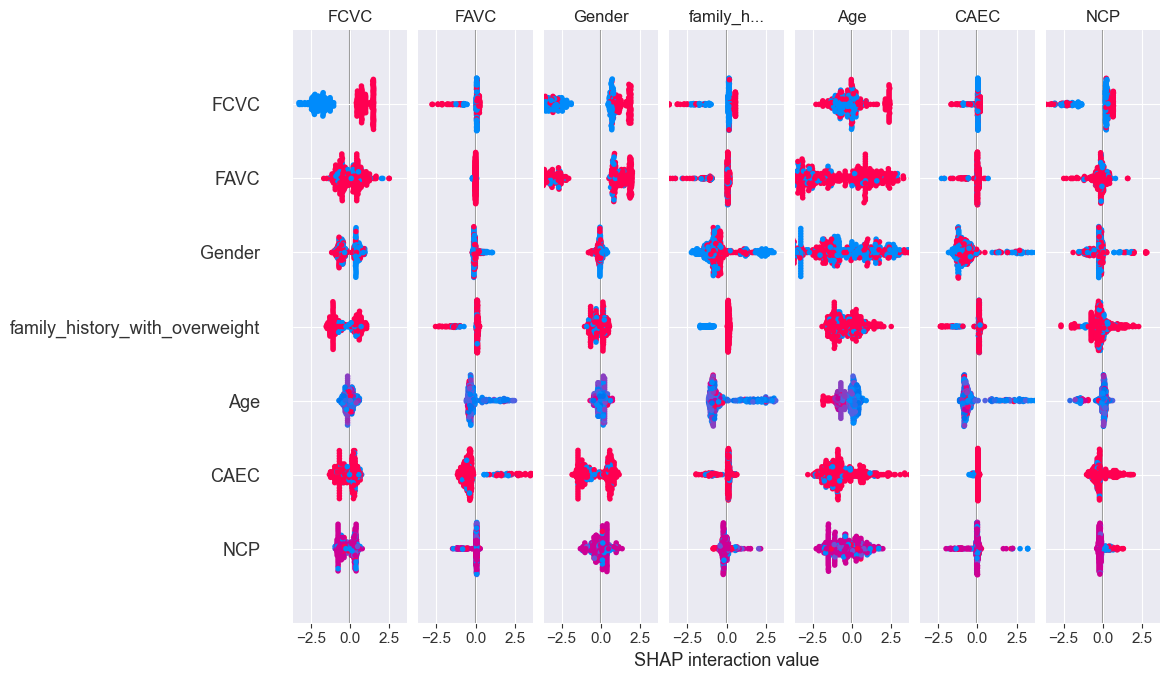

In [44]:
# aplicar SHAP para entender como las características afectan la predicción

import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


In [45]:
# Create an Explanation object

shap_values_exp = shap.Explanation(values=shap_values, 
                                   base_values=explainer.expected_value, 
                                   data=X_test, feature_names=X_test.columns)

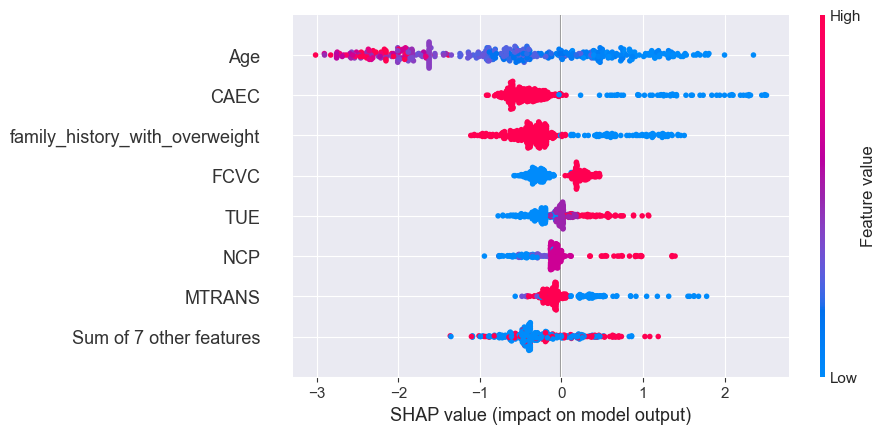

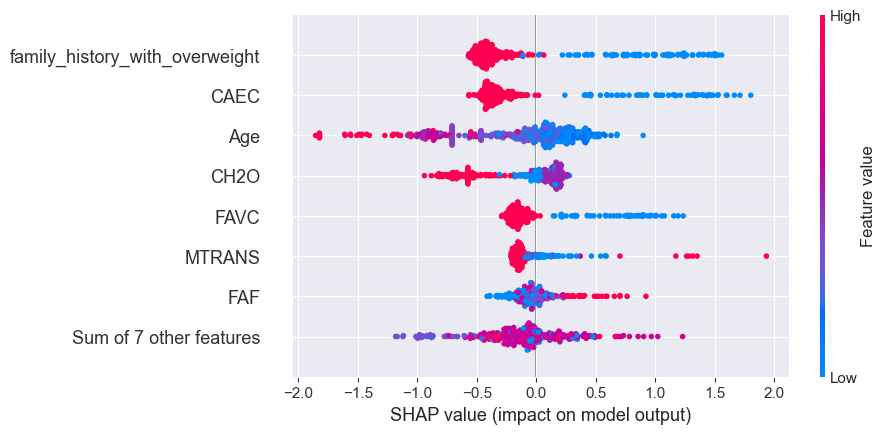

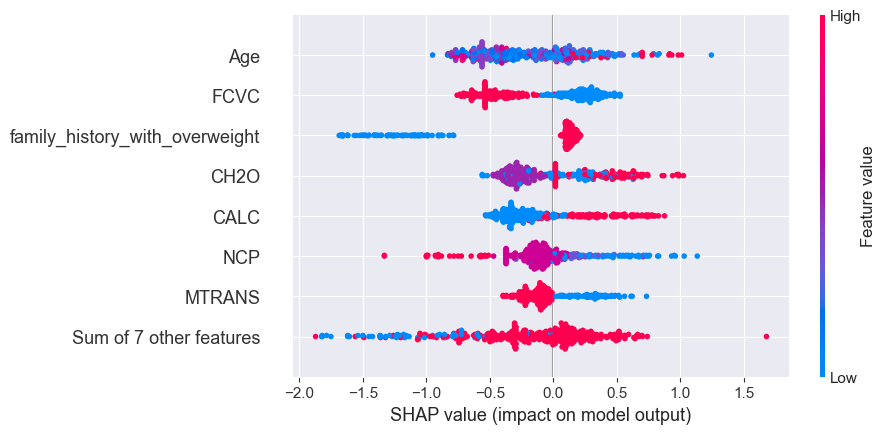

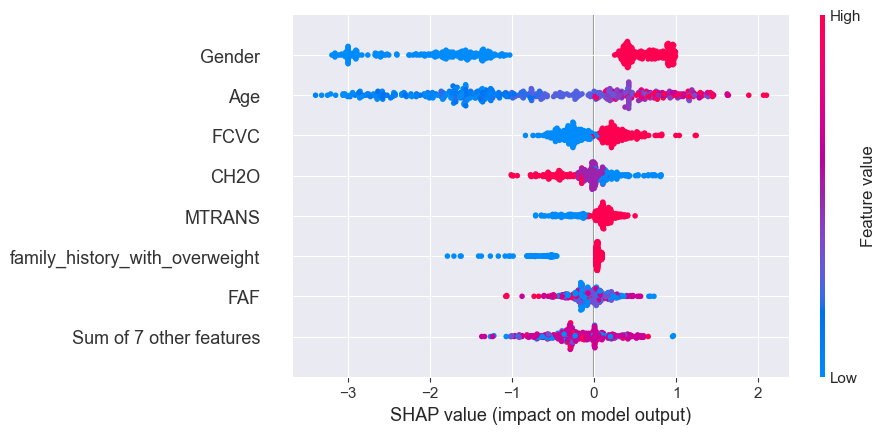

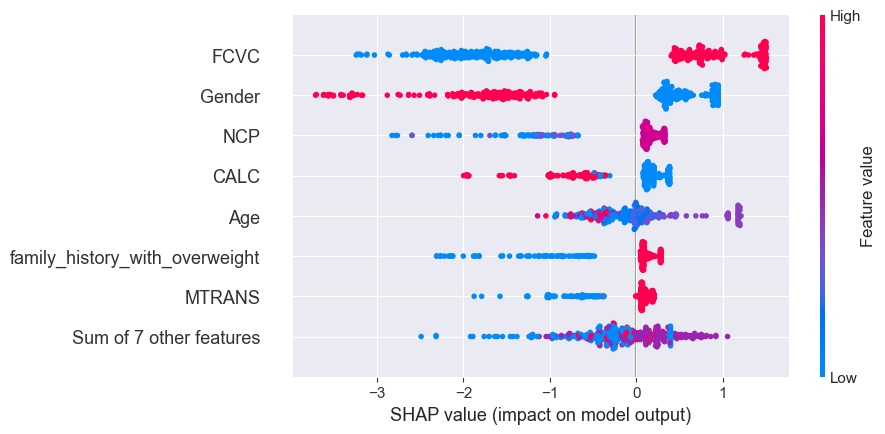

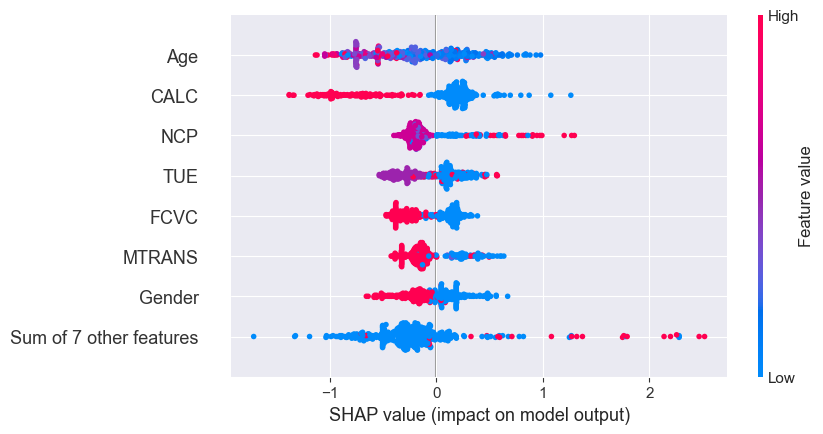

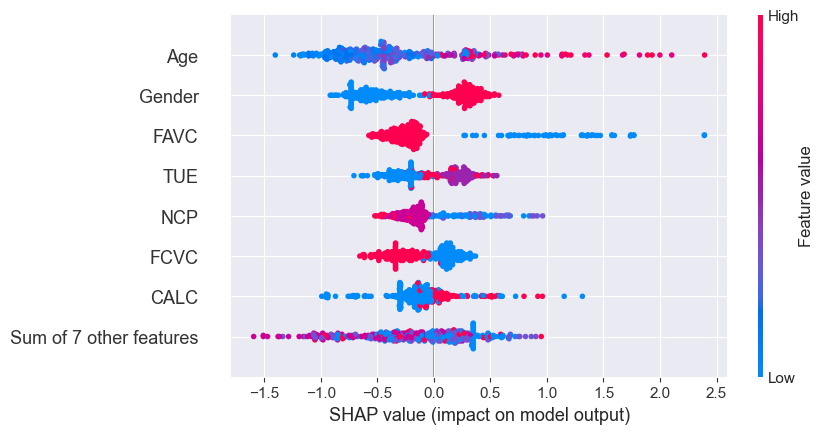

In [46]:
# graficar los valores SHAP de todas las salidas del modelo

for i in range(7):
    shap.plots.beeswarm(shap_values_exp[:,:,i], max_display=8)
